# PRNet: Progressive Resolution based Network for Radiograph based disease classification

- Reproduce the architecture and results from the PRNet paper
  - paper link: file:///Users/Raahim/Documents/LUMS/Sophomore/Sophomore%20Summer%20semester%202025/research/maanz-ai%20internship/PRNet_Progressive_Resolution_based_Network_for_Radiograph_based_disease_classification.pdf (attach official link or github link)
  - dataset: https://cxr-covid19.grand-challenge.org/
  - backup dataset: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database




## 0. Starter code

In [1]:
import os, random, time
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm.auto import tqdm
import shutil
import warnings

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, utils
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
# fix random seeds for reproducibility
def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_global_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 1. Readying code: Dataset, transforms and visualizations

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [4]:
import os

# List folders/files inside the dataset root directory
for root, dirs, files in os.walk(path):
    print(f"\nInspecting folder: {root}")
    print("Subdirectories:", dirs)
    print("Files:", files)
    # break  # Only list top-level directories (remove this to go deeper)



Inspecting folder: /kaggle/input/covid19-radiography-database
Subdirectories: ['COVID-19_Radiography_Dataset']
Files: []

Inspecting folder: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset
Subdirectories: ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']
Files: ['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx']

Inspecting folder: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal
Subdirectories: ['images', 'masks']
Files: []

Inspecting folder: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images
Subdirectories: []
Files: ['Normal-859.png', 'Normal-158.png', 'Normal-10121.png', 'Normal-1811.png', 'Normal-97.png', 'Normal-1088.png', 'Normal-5663.png', 'Normal-6328.png', 'Normal-8410.png', 'Normal-5641.png', 'Normal-4852.png', 'Normal-9518.png', 'Normal-6443.png', 'Normal-6391.png', 'Normal-8481.png', 'Normal-3896.png', '

In [5]:
# set the base paths
base_dataset_path = os.path.join(path, "COVID-19_Radiography_Dataset")
output_base = "data"
splits = ['train', 'val', 'test']
split_ratio = [0.8, 0.1, 0.1]  # 70% train, 15% val, 15% test
classes = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

# create output directories
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(output_base, split, class_name), exist_ok=True)

# function to split and copy images
for class_name in classes:
    source_dir = os.path.join(base_dataset_path, class_name, "images")
    all_images = os.listdir(source_dir)
    random.shuffle(all_images)
    n_total = len(all_images)
    n_train = int(split_ratio[0] * n_total)
    n_val = int(split_ratio[1] * n_total)
    train_images = all_images[:n_train]
    val_images = all_images[n_train:n_train + n_val]
    test_images = all_images[n_train + n_val:]

    def copy_images(image_list, split_name):
        for image in tqdm(image_list, desc=f"{split_name} - {class_name}"):
            src = os.path.join(source_dir, image)
            dst = os.path.join(output_base, split_name, class_name, image)
            shutil.copyfile(src, dst)
    copy_images(train_images, "train")
    copy_images(val_images, "val")
    copy_images(test_images, "test")

train - COVID:   0%|          | 0/2892 [00:00<?, ?it/s]

val - COVID:   0%|          | 0/361 [00:00<?, ?it/s]

test - COVID:   0%|          | 0/363 [00:00<?, ?it/s]

train - Normal:   0%|          | 0/8153 [00:00<?, ?it/s]

val - Normal:   0%|          | 0/1019 [00:00<?, ?it/s]

test - Normal:   0%|          | 0/1020 [00:00<?, ?it/s]

train - Viral Pneumonia:   0%|          | 0/1076 [00:00<?, ?it/s]

val - Viral Pneumonia:   0%|          | 0/134 [00:00<?, ?it/s]

test - Viral Pneumonia:   0%|          | 0/135 [00:00<?, ?it/s]

train - Lung_Opacity:   0%|          | 0/4809 [00:00<?, ?it/s]

val - Lung_Opacity:   0%|          | 0/601 [00:00<?, ?it/s]

test - Lung_Opacity:   0%|          | 0/602 [00:00<?, ?it/s]

In [6]:
# loading dataset
# class ChestXRayDataset(Dataset):
#   def __init__(self, root_dir: str, class_names: list, transform=None):
#     self.image_paths = []
#     self.labels = []
#     for idx, class_name in enumerate(class_names):
#       class_dir = os.path.join(root_dir, class_name)
#       files = glob(class_dir) # get all images of each class
#       self.image_paths += files
#       self.labels += [idx] * len(files) # appends label for each class image found
#     self.transform = transform

#   def __len__(self):
#     return len(self.image_paths)

#   def __getitem__(self, index):
#     image_path = self.image_paths[index]
#     image = Image.open(image_path).convert("RGB")
#     label = self.labels[index]
#     if self.transform:
#       image = self.transform(image)
#     return image, label
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, class_names, transform=None):
        # self.data_dir = data_dir
        # self.class_names = class_names
        # self.transform = transform
        # self.image_paths = []
        # self.labels = []
        # for class_name in class_names:
        #     class_dir = os.path.join(data_dir, class_name)
        #     for fname in os.listdir(class_dir):
        #         fpath = os.path.join(class_dir, fname)
        #         if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        #             self.image_paths.append((fpath, class_name))
        #             self.labels.append()
        self.image_paths = []
        self.labels = []
        for idx, class_name in enumerate(class_names):
            class_dir = os.path.join(data_dir, class_name)
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(('.png','jpg','jpeg')):
                    self.image_paths.append(fpath)
                    self.labels.append(idx)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image) # PIL → H×W×C numpy array
        if self.transform:
            augmented = self.transform(image=image) # must pass as keyword
            image = augmented['image'] # grab the transformed tensor

        return image, label

In [7]:
# transformations
def get_train_augmentations(image_size: int):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        # A.RandomBrightness(limit=0.2, p=0.3), # changes image brightness to mimic lighting variation # search for right import
        # A.RandomContrast(limit=0.2, p=0.3), # modifies contrast to handle visual differences
        A.Blur(blur_limit=3, p=0.2), # general softening of the image
        A.MedianBlur(blur_limit=3, p=0.2), # removes noise while keeping edges sharp
        A.GaussianBlur(blur_limit=(3,5), p=0.2), # natural smooth blur like out-of-focus camera
        A.MotionBlur(blur_limit=5, p=0.2), # simulates camera shake or patient movement
        A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3), # lens-like warping of image
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3), # distorts image with grid pattern
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3), # adjusts tint, saturation, brightness
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5), # shifts, zooms, rotates image slightly
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_augmentations(image_size: int):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2(),
    ])


In [8]:
# visualize images
def imshow(img_tensor, mean, std):
    """
    img_tensor: C×H×W torch Tensor, normalized
    mean, std: sequences of length C
    returns: H×W×C numpy array in [0,1]
    """
    # move to C×H×W numpy
    img = img_tensor.cpu().numpy()
    # unnormalize per channel
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    # transpose to H×W×C
    img = np.transpose(img, (1,2,0))
    # clip to valid range
    return np.clip(img, 0, 1)

def show_batch(dataset, class_names, num_samples=16):
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, labels = next(iter(loader))

    # constants – must match your Normalize()
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)

    n = int(num_samples**0.5)  # for a 4×4 grid if num_samples=16
    fig, axes = plt.subplots(n, n, figsize=(n*4, n*4))

    for ax, img_t, lab in zip(axes.flatten(), images, labels):
        img = imshow(img_t, mean, std)
        ax.imshow(img)
        ax.set_title(class_names[lab], fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# def show_batch(dataset, class_names, num_samples=16):
#     loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
#     images, labels = next(iter(loader))
#     # 4×4 grid
#     n = int(num_samples**0.5)
#     fig, axes = plt.subplots(n, n, figsize=(n*4, n*4))
#     for ax, img, lab in zip(axes.flatten(), images, labels):
#         # img is C×H×W tensor in [0,1]; move to H×W×C:
#         ax.imshow(img.permute(1, 2, 0).cpu().numpy())
#         ax.set_title(class_names[lab], fontsize=12)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

/tmp/ipykernel_36/1779862192.py:12: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3), # lens-like warping of image
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Raw images: 


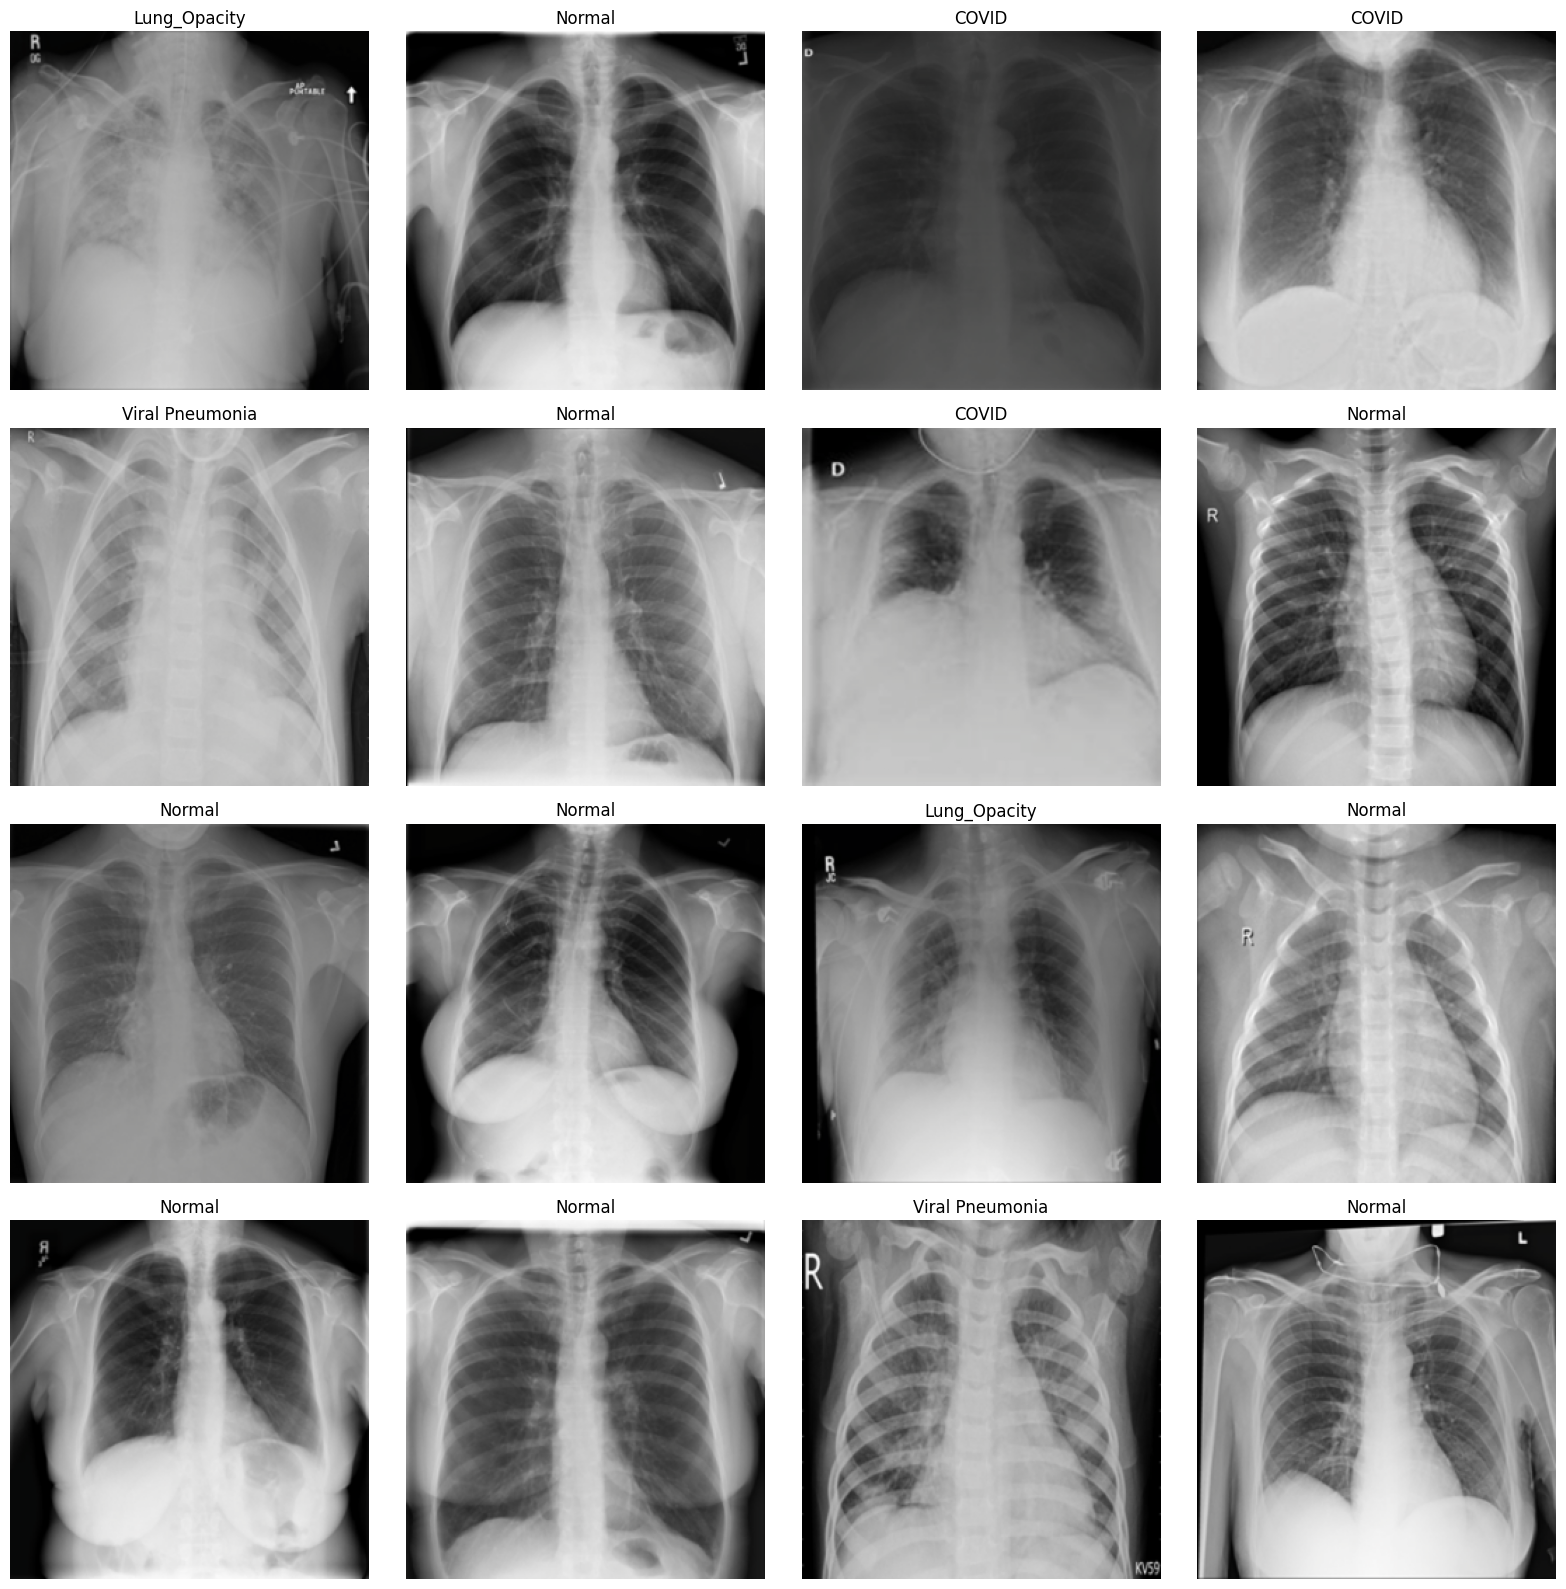

In [9]:
# usage
train_dir = "/kaggle/working/data/train"
class_names = sorted(os.listdir(train_dir))
raw_dataset = ChestXRayDataset(train_dir, class_names, transform=get_val_augmentations(256))
aug_dataset = ChestXRayDataset(train_dir, class_names, transform=get_train_augmentations(256))
print("Raw images: ")
show_batch(raw_dataset, class_names)

Augmented images: 


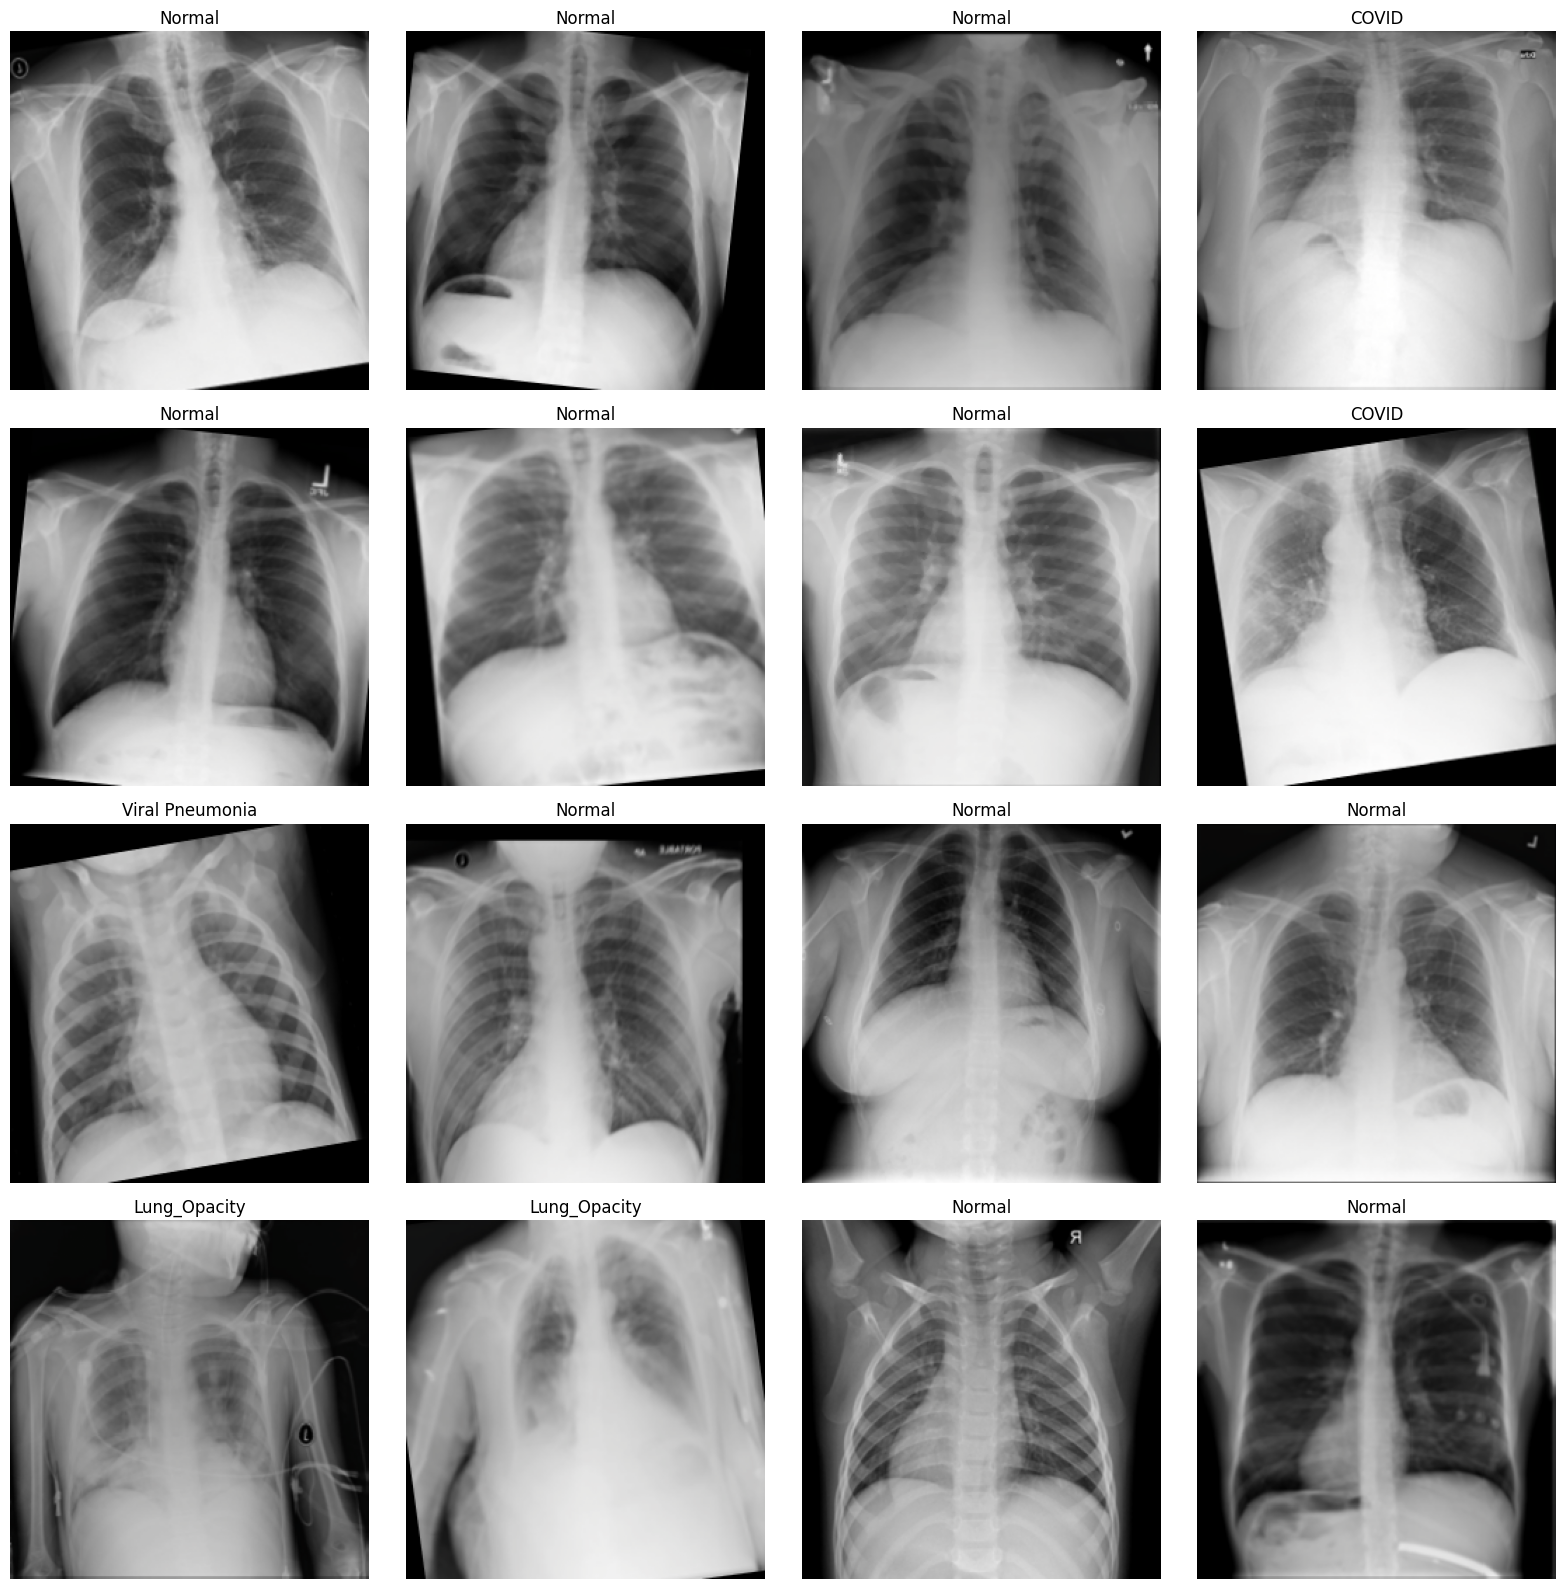

In [10]:
print("Augmented images: ")
show_batch(aug_dataset, class_names)

## 2. Model definitions

In [11]:
# class PRNetEffNetB5(nn.Module):
#   def __init__(self, num_classes: int):
#     super().__init__()
#     self.backbone = timm.create_model('efficientnet_b5', pretrained=True, features_only=True) # defining own classification head
#     num_channels = self.backbone.feature_info[-1]["num_chs"] # get the most abstract feature_map from the the backbone layer
#     self.global_pool = nn.AdapativeAvgPool2d(1)
#     self.classifier_dropout = nn.Dropout(p=0.5)
#     self.classifier = nn.Linear(num_channels, num_classes)

#   def forward(self, x):
#     features = self.backbone(x)[-1]
#     pooled = self.global_pool(features).flatten(1) # takes output of [B, C, H, W] and coverts it to [B, C, 1, 1] or [B, C]
#     dropped = self.classifier_dropout(pooled)
#     logits = self.classifier(dropped)
#     return logits

In [12]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, name, num_classes):
        super().__init__()
        self.backbone = timm.create_model(name, pretrained=True, features_only=True)
        in_ch = self.backbone.feature_info[-1]["num_chs"]
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(in_ch, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)[-1]  # take the deepest feature map only
        out = self.head(feats)
        return out

def create_effnet_backbone(name, num_classes):
    return EfficientNetClassifier(name, num_classes).to(device)

# def create_effnet_backbone(name, num_classes):
#     # name="efficientnet_b0" or "efficientnet_b5"
#     backbone = timm.create_model(name, pretrained=True, features_only=True)
#     in_ch = backbone.feature_info[-1]["num_chs"]  # get the most abstract feature_map from the the backbone layer
#     head = nn.Sequential(
#         nn.AdaptiveAvgPool2d(1),
#         nn.Flatten(),
#         nn.Dropout(0.5),
#         nn.Linear(in_ch, num_classes)
#     )
#     model = nn.Sequential(backbone, head)
#     return model.to(device)

In [13]:
# class VisionTransformerStub(nn.Module):
#     def __init__(self, num_classes: int):
#         super().__init__()
#         self.vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
#     def forward(self, x):
#         return self.vit(x)

## 3. Bias-adjustable Softmax

In [14]:
# def bias_softmax(logits, exps):
#     probs = torch.softmax(logits, dim=-1)
#     adj   = probs ** torch.tensor(exps, device=probs.device)
#     return adj / adj.sum(-1, keepdim=True)

# def search_biased_exponents(val_loader, model, exp_range=(0.0,5.0), step=0.1):
#     model.eval()
#     all_logits = []
#     all_labels = []
#     with torch.no_grad():
#         for imgs, lbls in val_loader:
#             imgs = imgs.to(device)
#             all_logits.append(model(imgs).cpu())
#             all_labels.append(torch.tensor(lbls))
#     all_logits = torch.cat(all_logits)
#     all_labels = torch.cat(all_labels)
#     best = [1.0]*all_logits.size(1)
#     for c in range(all_logits.size(1)):
#         best_acc,best_p=0,1.0
#         for p in np.arange(exp_range[0], exp_range[1]+1e-9, step):
#             exps = best.copy()
#             exps[c] = p
#             preds = bias_softmax(all_logits, exps).argmax(1)
#             acc = (preds==all_labels).float().mean().item()
#             if acc>best_acc: best_acc,best_p=acc,p
#         best[c]=best_p
#     return best


In [15]:
def bias_softmax(logits, exponents):
    """
    applies bias-adjustable softmax to modify class probabilities

    how it works:
    1. get normal softmax probabilities (0 to 1, sum to 1)
    2. raise each class probability to its own exponent
       - exponent > 1: makes high probs higher, low probs lower (sharpens)
       - exponent < 1: makes distribution more uniform (smooths)
       - exponent = 1: no change (normal softmax)
    3. renormalize so they still sum to 1

    example:
    - normal probs: [0.6, 0.3, 0.1]
    - exponents: [1.0, 0.5, 2.0]
    - after power: [0.6^1.0, 0.3^0.5, 0.1^2.0] = [0.6, 0.55, 0.01]
    - after normalize: [0.52, 0.47, 0.01] (approximately)

    args:
        logits: model outputs before softmax, shape (batch_size, num_classes)
        exponents: list of exponents for each class, length = num_classes

    returns:
        adjusted probabilities, same shape as input
    """
    # step 1: get normal softmax probabilities
    normal_probs = torch.softmax(logits, dim=-1)

    # step 2: raise each class to its exponent
    # convert exponents to tensor on same device as probabilities
    exp_tensor = torch.tensor(exponents, device=normal_probs.device)
    adjusted_probs = normal_probs ** exp_tensor

    # step 3: renormalize so each row sums to 1
    # sum across classes (dim=-1) and keep dimension for broadcasting
    normalized = adjusted_probs / adjusted_probs.sum(dim=-1, keepdim=True)

    return normalized


def search_best_exponents(validation_loader, trained_model, search_range=(0.1, 3.0), step_size=0.1):
    """
    finds the best exponent for each class using grid search

    the idea:
    - for each class, try different exponent values
    - pick the exponent that gives highest validation accuracy
    - do this one class at a time (greedy search)

    why this works:
    - if a class is being under-predicted, use exponent > 1 to boost it
    - if a class is being over-predicted, use exponent < 1 to dampen it
    - the paper found exponents [1.0, 0.4, 1.6] for covid/pneumonia/normal
      meaning pneumonia was over-predicted so they dampened it with 0.4

    args:
        validation_loader: dataloader for validation set
        trained_model: the model to tune (should be already trained)
        search_range: (min_exp, max_exp) to search
        step_size: how fine-grained the search is

    returns:
        list of best exponents for each class
    """
    print("collecting validation predictions for bias tuning...")

    # put model in evaluation mode
    trained_model.eval()

    # collect all validation data predictions in one go
    # this is more efficient than running inference multiple times
    all_logits = []  # model outputs (before softmax)
    all_true_labels = []

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            logits = trained_model(images)
            all_logits.append(logits.cpu()) # move back to CPU for storage (saves GPU memory)
            # labels might already be tensors, but ensure they're tensors
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels)
            all_true_labels.append(labels)

    # combine all batches into single tensors
    all_logits = torch.cat(all_logits, dim=0)  # shape: (total_samples, num_classes)
    all_true_labels = torch.cat(all_true_labels, dim=0)  # shape: (total_samples,)
    num_classes = all_logits.size(1)
    print(f"collected {all_logits.size(0)} samples with {num_classes} classes")

    # start with default exponents (no bias adjustment)
    best_exponents = [1.0] * num_classes

    # optimize each class exponent one by one
    for class_idx in range(num_classes):
        print(f"tuning exponent for class {class_idx}...")

        best_accuracy = 0.0
        best_exponent = 1.0

        # try different exponent values for this class
        search_values = np.arange(search_range[0], search_range[1] + step_size/2, step_size)

        for exp_value in search_values:
            # create exponent list with only this class modified
            test_exponents = best_exponents.copy()
            test_exponents[class_idx] = exp_value

            # apply bias-adjustable softmax with these exponents
            adjusted_probs = bias_softmax(all_logits, test_exponents)

            # get predictions (highest probability class)
            predictions = adjusted_probs.argmax(dim=1)

            # calculate accuracy
            correct = (predictions == all_true_labels).float()
            accuracy = correct.mean().item()

            # keep track of best exponent for this class
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_exponent = exp_value

        # update the best exponent for this class
        best_exponents[class_idx] = best_exponent
        print(f"  class {class_idx}: best_exponent={best_exponent:.2f}, accuracy={best_accuracy:.4f}")

    print(f"final best exponents: {best_exponents}")
    return best_exponents


# example usage:
"""
# after training your model, tune the bias exponents
model = your_trained_model
val_loader = your_validation_dataloader

# find best exponents
optimal_exponents = search_best_exponents(val_loader, model)

# then during inference on test set:
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(DEVICE)
        logits = model(test_images)

        # apply bias adjustment
        adjusted_probs = bias_softmax(logits, optimal_exponents)
        predictions = adjusted_probs.argmax(dim=1)

        # calculate test accuracy with bias adjustment
        ...
"""

'\n# after training your model, tune the bias exponents\nmodel = your_trained_model\nval_loader = your_validation_dataloader\n\n# find best exponents\noptimal_exponents = search_best_exponents(val_loader, model)\n\n# then during inference on test set:\nwith torch.no_grad():\n    for test_images, test_labels in test_loader:\n        test_images = test_images.to(DEVICE)\n        logits = model(test_images)\n\n        # apply bias adjustment\n        adjusted_probs = bias_softmax(logits, optimal_exponents)\n        predictions = adjusted_probs.argmax(dim=1)\n\n        # calculate test accuracy with bias adjustment\n        ...\n'

## 4. Training + Validation

Dropout (in your model):

Randomly sets some neurons to zero during training
Prevents neurons from becoming too dependent on each other
Applied to activations/features

Weight Decay (in optimizer):

Penalizes large weight values directly
Keeps weights small to prevent overfitting
Applied to the actual model parameters

Why Use Both?
They target different aspects of overfitting:
Dropout prevents co-adaptation - stops neurons from memorizing specific patterns together
Weight Decay prevents parameter explosion - stops individual weights from becoming too large

In [16]:
def create_warmup_cosine_scheduler(optimizer, total_epochs, warmup_epochs=3, min_lr=1e-7):
    """
    Returns a SequentialLR that:
     - linearly warms lr from 0→initial over `warmup_epochs`
     - then cosine-anneals from initial→`min_lr` over remaining epochs
     - LR = min_lr + 0.5 * (max_lr - min_lr) * (1 + cos(π * current_step / T_max))
    """
    # warmup: 0 → 1×LR
    warmup = LinearLR(
        optimizer,
        start_factor=1e-3,
        end_factor=1.0,
        total_iters=warmup_epochs
    )
    # cosine: 1×LR → min_lr
    cosine = CosineAnnealingLR(
        optimizer,
        T_max=max(total_epochs - warmup_epochs, 1), # ensures atleast T_max = 1 to avoid division by 0 in cosin formular
        eta_min=min_lr
    )
    # join them at warmup_epochs
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup, cosine],
        milestones=[warmup_epochs]
    )
    return scheduler

In [39]:
def plot_metrics_per_model(results):
    """
    For each result dict in `results`, creates a figure with two side-by-side plots:
      - Left: Loss curves (train, val, and horizontal test line)
      - Right: Accuracy curves (train, val, and horizontal test line)

    Assumes each dict has keys:
      'ConfigLabel', 'Train Losses', 'Val Losses', 'Test Loss',
      'Train Accs', 'Val Accs', 'Test Acc'.
    """
    for r in results:
        label = r.get('ConfigLabel', r.get('Backbone', 'Model'))
        epochs = range(1, len(r['Train Losses']) + 1)
        fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 4))

        # loss plot
        ax_loss.plot(epochs, r['Train Losses'], label='Train Loss')
        ax_loss.plot(epochs, r['Val Losses'], label='Val Loss')
        ax_loss.hlines(r['Test Loss'], xmin=1, xmax=epochs[-1], linestyles='--', label='Test Loss')
        ax_loss.set_title(f'{label} Loss')
        ax_loss.set_xlabel('Epoch')
        ax_loss.set_ylabel('Loss')
        ax_loss.legend()
        ax_loss.grid(True)

        # accuracy plot
        ax_acc.plot(epochs, r['Train Accs'], label='Train Acc')
        ax_acc.plot(epochs, r['Val Accs'], label='Val Acc')
        ax_acc.hlines(r['Test Accuracy'], xmin=1, xmax=20, linestyles='--', label='Test Acc')
        ax_acc.set_title(f'{label} Accuracy')
        ax_acc.set_xlabel('Epoch')
        ax_acc.set_ylabel('Accuracy')
        ax_acc.legend()
        ax_acc.grid(True)

        plt.tight_layout()
        filename = f"{label.replace(' ', '_')}_metrics.png"
        plt.savefig(filename)
        print(f"Saved plot as {filename}")
        display(FileLink(filename))
        plt.show()

In [33]:
import logging
from torch.cuda.amp import GradScaler, autocast

# dataset = ChestXRayDataset()  # assumed imported

def run_configuration(
    backbone_name: str,
    image_size: int,
    use_progressive: bool,
    use_bas: bool,
    data_dir: str = "/kaggle/working/data",
    total_epochs: int = 20,
    batch_size: int = 16,  # base batch size
    base_lr: float = 1e-4,
    weight_decay: float = 1e-4,
    early_stopping_patience: int = 5
) -> dict:
    # suppress warnings and logging
    warnings.filterwarnings("ignore")
    logging.getLogger().setLevel(logging.ERROR)
    logging.getLogger("timm.models._builder").setLevel(logging.ERROR)

    # setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class_names = sorted(os.listdir(f"{data_dir}/train"))
    num_classes = len(class_names)
    model = create_effnet_backbone(backbone_name, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    scheduler = create_warmup_cosine_scheduler(optimizer, total_epochs)

    # prepare AMP scaler
    scaler = GradScaler()

    # figure out what image sizes we're gonna use
    # if progressive: start small and work our way up like the paper says
    # if not: just use the final size the whole time
    stages = [image_size] if not use_progressive else [256, 380, 460, 512, image_size]
    epochs_per_stage = total_epochs // len(stages)
    prev_ckpt = None
    best_overall_ckpt = None
    total_train_time = total_val_time = 0.0
    best_overall_train_acc = best_overall_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for stage_idx, sz in enumerate(stages, 1):
        # adjust batch size for large resolutions
        stage_bs = batch_size if sz < 512 else max(1, batch_size // 2)
        print(f"starting stage {stage_idx}/{len(stages)}: resolution {sz}x{sz}, batch size {stage_bs}")

        # load previous weights (if we have one)
        if prev_ckpt:
            model.load_state_dict(torch.load(prev_ckpt))
            print(f"Loaded checkpoint: {prev_ckpt}")

        # data loaders
        train_loader = DataLoader(
            ChestXRayDataset(f"{data_dir}/train", class_names, transform=get_train_augmentations(sz)),
            batch_size=stage_bs, shuffle=True, num_workers=2
        )
        val_loader = DataLoader(
            ChestXRayDataset(f"{data_dir}/val", class_names, transform=get_val_augmentations(sz)),
            batch_size=stage_bs, shuffle=False, num_workers=2
        )

        # for early stopping
        epochs_no_improve = 0
        best_stage_val_acc = 0.0

        for epoch in range(1, epochs_per_stage + 1):
            # TRAIN
            model.train()
            t0 = time.time()
            running_loss = correct = total = 0
            train_bar = tqdm(train_loader, desc=f"stage {stage_idx} @{sz}px - training epoch {epoch}", leave=False)
            for imgs, lbls in train_bar:
                imgs, lbls = imgs.to(device), lbls.to(device)
                optimizer.zero_grad()

                # forward pass
                with autocast():
                    logits = model(imgs)
                    loss = criterion(logits, lbls)

                # backward pass
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # track accuracy for this batch
                running_loss += loss.item() * lbls.size(0)
                preds = logits.argmax(1)
                correct += (preds == lbls).sum().item()
                total += lbls.size(0)

                # update progress bar with current accuracy
                current_acc = correct / total
                train_bar.set_postfix({'acc': f'{current_acc:.3f}'})

            epoch_train_time = time.time() - t0
            total_train_time += epoch_train_time
            epoch_train_loss = running_loss / total
            epoch_train_acc = correct / total
            train_accs.append(epoch_train_acc)
            train_losses.append(epoch_train_loss)

            # VALIDATION
            model.eval()
            t1 = time.time()
            val_loss_sum = correct_val = tot_val = 0
            val_bar = tqdm(val_loader, desc=f"stage {stage_idx} @{sz}px - validating epoch {epoch}", leave=False)
            with torch.no_grad():
                for imgs, lbls in val_bar:
                    imgs, lbls = imgs.to(device), lbls.to(device)
                    with autocast():
                        logits = model(imgs)
                        loss = criterion(logits, lbls)

                    val_loss_sum += loss.item() * lbls.size(0)
                    preds = logits.argmax(1)
                    correct_val += (preds == lbls).sum().item()
                    tot_val += lbls.size(0)

                    # show current val accuracy in progress bar
                    current_val_acc = correct_val / tot_val
                    val_bar.set_postfix({'val_acc': f'{current_val_acc:.3f}'})

            epoch_val_time = time.time() - t1
            total_val_time += epoch_val_time
            epoch_val_acc = correct_val / tot_val
            epoch_val_loss = val_loss_sum / tot_val
            val_accs.append(epoch_val_acc)
            val_losses.append(epoch_val_loss)

            print(f"\nEpoch {epoch}: train_acc={epoch_train_acc:.4f}, val_acc={epoch_val_acc:.4f}, train_loss={epoch_train_loss:.4f}, val_loss={epoch_val_loss:.4f}")

            # clear cache
            torch.cuda.empty_cache()

            ## check if this is the best validation accuracy we've seen in this stage
            if epoch_val_acc > best_stage_val_acc:
                best_stage_val_acc = epoch_val_acc
                epochs_no_improve = 0
                
                # save the model - this is our best checkpoint so far
                prev_ckpt = f"{backbone_name}_stage{stage_idx}_{sz}.pth"
                torch.save(model.state_dict(), prev_ckpt)
                print(f"new best val acc: {epoch_val_acc:.4f} - saved to {prev_ckpt}")
                
                # update our global best accuracies if this beats them
                if epoch_train_acc > best_overall_train_acc:
                    best_overall_train_acc = epoch_train_acc
                    print(f"new overall best train acc: {epoch_train_acc:.4f}")
                    
                if epoch_val_acc > best_overall_val_acc:
                    best_overall_val_acc = epoch_val_acc
                    best_overall_ckpt = prev_ckpt
                    print(f"new overall best val acc: {epoch_val_acc:.4f}")
                    
            else:
                epochs_no_improve += 1
                print(f"no improvement for {epochs_no_improve} epochs")
                
                # early stopping check
                if epochs_no_improve >= early_stopping_patience:
                    print(f"early stopping triggered at stage {stage_idx}, epoch {epoch}")
                    break

            # update learning rate
            scheduler.step()

        # if we early stopped, don't continue to next stages
        if epochs_no_improve >= early_stopping_patience:
            print("\nearly stopping triggered - stopping all stages")
            break
        print("\n")

    # load up the best model we found
    if best_overall_ckpt:
        model.load_state_dict(torch.load(best_overall_ckpt))
        # print(f"loaded best model from {prev_ckpt}")
        print(f"✅ loaded best validation model from {best_overall_ckpt} (val_acc={best_overall_val_acc:.4f})")

    # bias-adjustable softmax tuning (only if requested)
    best_exps = [1.0] * num_classes  # default exponents
    if use_bas:
        print("tuning bias-adjustable softmax on validation set...")
        final_val_loader = DataLoader(
            ChestXRayDataset(f"{data_dir}/val", class_names, transform=get_val_augmentations(image_size)),
            batch_size=batch_size, shuffle=False, num_workers=4
        )
        best_exps = search_best_exponents(final_val_loader, model)
        print(f"best bias exponents: {best_exps}")

    # final test evaluation
    print("running final test evaluation...")
    t2 = time.time()
    total_test_loss = correct_test = tot_test = 0
    
    test_loader = DataLoader(
        ChestXRayDataset(f"{data_dir}/test", class_names, transform=get_val_augmentations(image_size)),
        batch_size=batch_size, shuffle=False, num_workers=4
    )
    
    model.eval()
    with torch.no_grad():
        for imgs, lbls in tqdm(test_loader, desc="Final test evaluation"):
            imgs, lbls = imgs.to(device), lbls.to(device)
            logits = model(imgs)
            loss = criterion(logits, lbls)
            total_test_loss += loss.item() * lbls.size(0)
            
            # apply bias-adjustable softmax if we're using it
            if use_bas:
                logits = bias_softmax(logits, best_exps)
                
            preds = logits.argmax(1)
            correct_test += (preds==lbls).sum().item()
            tot_test += lbls.size(0)
            
    test_acc  = correct_test / tot_test
    test_loss = total_test_loss / tot_test
    test_time = time.time() - t2
    
    print(f"\nfinal results:")
    print(f"  best train acc (across all stages): {best_overall_train_acc:.4f}")
    print(f"  best val acc (across all stages): {best_overall_val_acc:.4f}")
    print(f"  final test acc: {test_acc:.4f}")
  
    warnings.filterwarnings("ignore")

    # return results in the format that matches the paper's table (fix backbone name if running multiple models)
    return {
        "Backbone":       backbone_name.replace("efficientnet_","EffNet-").upper(), 
        "Image Size":     f"{image_size}×{image_size}",
        "Progressive":    "Yes" if use_progressive else "No",
        "Bias-Softmax":   "Yes" if use_bas else "No",
        "5-Fold Accuracy": f"{best_overall_train_acc*100:.2f}%",  # best train acc seen
        "Validation Accuracy": f"{best_overall_val_acc*100:.2f}%",  # best val acc seen
        "Test Accuracy":  f"{test_acc*100:.2f}%",  # final test performance
        "Train Time (s)": f"{total_train_time:.1f}",
        "Val Time (s)":   f"{total_val_time:.1f}",
        "Test Time (s)":  f"{test_time:.1f}",
        "Test Loss": f"{test_loss:.4f}",
        "Test Acc": f"{test_acc:.4f}",
        # for plotting only:
        "Train Losses": train_losses,
        "Val Losses": val_losses,
        "Train Accs": [a * 100 for a in train_accs],
        "Val Accs": [a * 100 for a in val_accs],
    }

In [19]:
configs = [
    # ("efficientnet_b0", 512, False, False),  # EffNet-B0, 512x512, no progressive, no bias
    # ("efficientnet_b0", 512, False, True),   # EffNet-B0, 512x512, no progressive, with bias
    # ("efficientnet_b0", 640, True,  False),  # EffNet-B0, 640x640, with progressive, no bias
    # ("efficientnet_b0", 640, True,  True),   # EffNet-B0, 640x640, with progressive, with bias
    # ("efficientnet_b5", 512, False, False),  # EffNet-B5, 512x512, no progressive, no bias
    # ("efficientnet_b5", 512, False, True),   # EffNet-B5, 512x512, no progressive, with bias
    # ("efficientnet_b5", 640, True,  False),  # EffNet-B5, 640x640, with progressive, no bias
    ("efficientnet_b5", 640, True,  True),   # EffNet-B5, 640x640, with progressive, with bias (their best)
]

# run all experiments
results = []
for i, (backbone, size, prog, bas) in enumerate(configs, 1):
    print(f"\n🚀 experiment {i}/{len(configs)}: {backbone} | size={size} | progressive={prog} | bias_softmax={bas}")

    res = run_configuration(
        backbone_name=backbone,
        image_size=size,
        use_progressive=prog,
        use_bas=bas,
        total_epochs=20,
        batch_size=16,
        early_stopping_patience=5
    )

    results.append(res)
    print(f"✅ completed: test_acc = {res['Test Accuracy']}")

# create the results table like in the paper
print("\n" + "="*80)
print("FINAL RESULTS TABLE (reproducing paper's Table I)")
print("="*80)


🚀 experiment 1/1: efficientnet_b5 | size=640 | progressive=True | bias_softmax=True


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

starting stage 1/5: resolution 256x256, batch size 16


stage 1 @256px - training epoch 1:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @256px - validating epoch 1:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 1: train_acc=0.1685, val_acc=0.1456
new best val acc: 0.1456 - saved to efficientnet_b5_stage1_256.pth
new overall best train acc: 0.1685
new overall best val acc: 0.1456


stage 1 @256px - training epoch 2:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @256px - validating epoch 2:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 2: train_acc=0.8395, val_acc=0.9305
new best val acc: 0.9305 - saved to efficientnet_b5_stage1_256.pth
new overall best train acc: 0.8395
new overall best val acc: 0.9305


stage 1 @256px - training epoch 3:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @256px - validating epoch 3:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 3: train_acc=0.9047, val_acc=0.9447
new best val acc: 0.9447 - saved to efficientnet_b5_stage1_256.pth
new overall best train acc: 0.9047
new overall best val acc: 0.9447


stage 1 @256px - training epoch 4:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 1 @256px - validating epoch 4:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 4: train_acc=0.9169, val_acc=0.9461
new best val acc: 0.9461 - saved to efficientnet_b5_stage1_256.pth
new overall best train acc: 0.9169
new overall best val acc: 0.9461


starting stage 2/5: resolution 380x380, batch size 16
Loaded checkpoint: efficientnet_b5_stage1_256.pth


stage 2 @380px - training epoch 1:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 2 @380px - validating epoch 1:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 1: train_acc=0.9302, val_acc=0.9551
new best val acc: 0.9551 - saved to efficientnet_b5_stage2_380.pth
new overall best train acc: 0.9302
new overall best val acc: 0.9551


stage 2 @380px - training epoch 2:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 2 @380px - validating epoch 2:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 2: train_acc=0.9422, val_acc=0.9560
new best val acc: 0.9560 - saved to efficientnet_b5_stage2_380.pth
new overall best train acc: 0.9422
new overall best val acc: 0.9560


stage 2 @380px - training epoch 3:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 2 @380px - validating epoch 3:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 3: train_acc=0.9483, val_acc=0.9556
no improvement for 1 epochs


stage 2 @380px - training epoch 4:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 2 @380px - validating epoch 4:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 4: train_acc=0.9540, val_acc=0.9598
new best val acc: 0.9598 - saved to efficientnet_b5_stage2_380.pth
new overall best train acc: 0.9540
new overall best val acc: 0.9598


starting stage 3/5: resolution 460x460, batch size 16
Loaded checkpoint: efficientnet_b5_stage2_380.pth


stage 3 @460px - training epoch 1:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 3 @460px - validating epoch 1:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 1: train_acc=0.9569, val_acc=0.9612
new best val acc: 0.9612 - saved to efficientnet_b5_stage3_460.pth
new overall best train acc: 0.9569
new overall best val acc: 0.9612


stage 3 @460px - training epoch 2:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 3 @460px - validating epoch 2:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 2: train_acc=0.9652, val_acc=0.9541
no improvement for 1 epochs


stage 3 @460px - training epoch 3:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 3 @460px - validating epoch 3:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 3: train_acc=0.9689, val_acc=0.9527
no improvement for 2 epochs


stage 3 @460px - training epoch 4:   0%|          | 0/1059 [00:00<?, ?it/s]

stage 3 @460px - validating epoch 4:   0%|          | 0/133 [00:00<?, ?it/s]


Epoch 4: train_acc=0.9752, val_acc=0.9617
new best val acc: 0.9617 - saved to efficientnet_b5_stage3_460.pth
new overall best train acc: 0.9752
new overall best val acc: 0.9617


starting stage 4/5: resolution 512x512, batch size 8
Loaded checkpoint: efficientnet_b5_stage3_460.pth


stage 4 @512px - training epoch 1:   0%|          | 0/2117 [00:00<?, ?it/s]

stage 4 @512px - validating epoch 1:   0%|          | 0/265 [00:00<?, ?it/s]


Epoch 1: train_acc=0.9646, val_acc=0.9584
new best val acc: 0.9584 - saved to efficientnet_b5_stage4_512.pth


stage 4 @512px - training epoch 2:   0%|          | 0/2117 [00:00<?, ?it/s]


Epoch 2: train_acc=0.9760, val_acc=0.9584
no improvement for 1 epochs


stage 4 @512px - training epoch 3:   0%|          | 0/2117 [00:00<?, ?it/s]

stage 4 @512px - validating epoch 3:   0%|          | 0/265 [00:00<?, ?it/s]


Epoch 3: train_acc=0.9820, val_acc=0.9593
new best val acc: 0.9593 - saved to efficientnet_b5_stage4_512.pth
new overall best train acc: 0.9820


stage 4 @512px - training epoch 4:   0%|          | 0/2117 [00:00<?, ?it/s]

stage 4 @512px - validating epoch 4:   0%|          | 0/265 [00:00<?, ?it/s]


Epoch 4: train_acc=0.9895, val_acc=0.9669
new best val acc: 0.9669 - saved to efficientnet_b5_stage4_512.pth
new overall best train acc: 0.9895
new overall best val acc: 0.9669


starting stage 5/5: resolution 640x640, batch size 8
Loaded checkpoint: efficientnet_b5_stage4_512.pth


stage 5 @640px - training epoch 1:   0%|          | 0/2117 [00:00<?, ?it/s]

stage 5 @640px - validating epoch 1:   0%|          | 0/265 [00:00<?, ?it/s]


Epoch 1: train_acc=0.9875, val_acc=0.9565
new best val acc: 0.9565 - saved to efficientnet_b5_stage5_640.pth


stage 5 @640px - training epoch 2:   0%|          | 0/2117 [00:00<?, ?it/s]

stage 5 @640px - validating epoch 2:   0%|          | 0/265 [00:00<?, ?it/s]


Epoch 2: train_acc=0.9933, val_acc=0.9641
new best val acc: 0.9641 - saved to efficientnet_b5_stage5_640.pth
new overall best train acc: 0.9933


stage 5 @640px - training epoch 3:   0%|          | 0/2117 [00:00<?, ?it/s]

stage 5 @640px - validating epoch 3:   0%|          | 0/265 [00:00<?, ?it/s]


Epoch 3: train_acc=0.9963, val_acc=0.9598
no improvement for 1 epochs


stage 5 @640px - training epoch 4:   0%|          | 0/2117 [00:00<?, ?it/s]

stage 5 @640px - validating epoch 4:   0%|          | 0/265 [00:00<?, ?it/s]


Epoch 4: train_acc=0.9974, val_acc=0.9669
new best val acc: 0.9669 - saved to efficientnet_b5_stage5_640.pth
new overall best train acc: 0.9974


✅ loaded best validation model from efficientnet_b5_stage4_512.pth (val_acc=0.9669)
tuning bias-adjustable softmax on validation set...
collecting validation predictions for bias tuning...
collected 2115 samples with 4 classes
tuning exponent for class 0...
  class 0: best_exponent=0.30, accuracy=0.9579
tuning exponent for class 1...
  class 1: best_exponent=1.50, accuracy=0.9622
tuning exponent for class 2...
  class 2: best_exponent=0.40, accuracy=0.9622
tuning exponent for class 3...
  class 3: best_exponent=0.40, accuracy=0.9626
final best exponents: [0.30000000000000004, 1.5000000000000002, 0.4, 0.4]
best bias exponents: [0.30000000000000004, 1.5000000000000002, 0.4, 0.4]
running final test evaluation...


Final test evaluation:   0%|          | 0/133 [00:00<?, ?it/s]


final results:
  best train acc (across all stages): 0.9974
  best val acc (across all stages): 0.9669
  final test acc: 0.9575
✅ completed: test_acc = 95.75%

FINAL RESULTS TABLE (reproducing paper's Table I)


In [37]:
results

[{'Backbone': 'EFFNET-B5',
  'Image Size': '640×640',
  'Progressive': 'Yes',
  'Bias-Softmax': 'Yes',
  '5-Fold Accuracy': '99.74%',
  'Validation Accuracy': '96.69%',
  'Test Accuracy': '95.75%',
  'Train Time (s)': '13017.4',
  'Val Time (s)': '486.4',
  'Test Time (s)': '82.3',
  'Test Loss': '0.1433',
  'Train Losses': [2.238654471147856,
   0.4644403344206182,
   0.2810620459944133,
   0.2442948495362964,
   0.19748784840212583,
   0.16951338499872487,
   0.1467589777106022,
   0.13551921376235657,
   0.11729253276311218,
   0.10271742949454797,
   0.08924760683288394,
   0.07007250205624124,
   0.10897917477815586,
   0.06973578249006952,
   0.05409102414531674,
   0.030232244057551122,
   0.03595218615495307,
   0.020647137945246148,
   0.01287937950820382,
   0.00901978617931215],
  'Val Losses': [1.680206948110116,
   0.20147249901549721,
   0.16285581622560602,
   0.15611755599930474,
   0.1317134965959734,
   0.1285067500797552,
   0.13027403653373923,
   0.12889397149954,


Saved plot as EFFNET-B5_metrics.png


/kaggle/working/EFFNET-B5_metrics.png

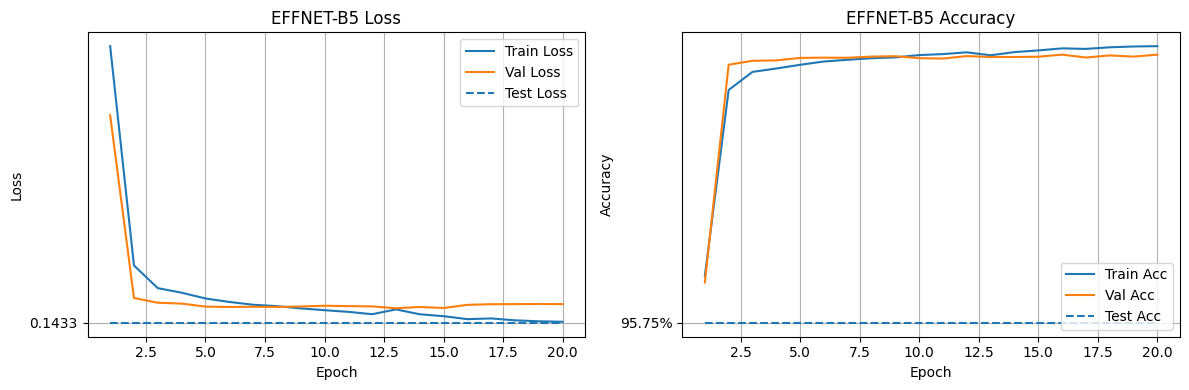

In [40]:
# plot loss and accuracy curves
plot_metrics_per_model(results)

In [45]:
# save results
flat_results = []
for r in results:
    flat = {k: v for k, v in r.items() if not isinstance(v, list)}
    flat_results.append(flat)

df = pd.DataFrame(flat_results)
df.to_csv("prnet_results.csv", index=False)
print(f"\nresults saved to prnet_results.csv")

# display results
from IPython.display import display, FileLink
df = pd.read_csv("prnet_results.csv")
display(df)


results saved to prnet_results.csv


,Backbone,Image Size,Progressive,Bias-Softmax,5-Fold Accuracy,Validation Accuracy,Test Accuracy,Train Time (s),Val Time (s),Test Time (s),Test Loss,Test Acc
0,EFFNET-B5,640×640,Yes,Yes,99.74%,96.69%,95.75%,13017.4,486.4,82.3,0.1433,0.9575


## 5. Training script

In [1]:
%%writefile train.py
# 0. imports
import os, random, time
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm.auto import tqdm
import shutil
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, utils
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import argparse
import sys
from IPython.display import display, FileLink
sys.stdout.reconfigure(line_buffering=True)

# 0.1 fix random seeds for reproducibility
def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_global_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1.1 LOAD DATASET
import kagglehub
# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
print("Path to dataset files:", path)

# List folders/files inside the dataset root directory
for root, dirs, files in os.walk(path):
    print(f"\nInspecting folder: {root}")
    print("Subdirectories:", dirs)
    # print("Files:", files)
    # break  # Only list top-level directories (remove this to go deeper)

# set the base paths
base_dataset_path = os.path.join(path, "COVID-19_Radiography_Dataset")
output_base = "data"
splits = ['train', 'val', 'test']
split_ratio = [0.8, 0.1, 0.1]  # 80% train, 10% val, 10% test
classes = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

# create output directories
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(output_base, split, class_name), exist_ok=True)

# function to split and copy images
for class_name in classes:
    source_dir = os.path.join(base_dataset_path, class_name, "images")
    all_images = os.listdir(source_dir)
    random.shuffle(all_images)
    n_total = len(all_images)
    n_train = int(split_ratio[0] * n_total)
    n_val = int(split_ratio[1] * n_total)
    train_images = all_images[:n_train]
    val_images = all_images[n_train:n_train + n_val]
    test_images = all_images[n_train + n_val:]

    def copy_images(image_list, split_name):
        for image in tqdm(image_list, desc=f"{split_name} - {class_name}"):
            src = os.path.join(source_dir, image)
            dst = os.path.join(output_base, split_name, class_name, image)
            shutil.copyfile(src, dst)
    copy_images(train_images, "train")
    copy_images(val_images, "val")
    copy_images(test_images, "test")

# 1.2 CREATE DATASET
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, class_names, transform=None):
        self.image_paths = []
        self.labels = []
        for idx, class_name in enumerate(class_names):
            class_dir = os.path.join(data_dir, class_name)
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(('.png','jpg','jpeg')):
                    self.image_paths.append(fpath)
                    self.labels.append(idx)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image) # PIL → H×W×C numpy array
        if self.transform:
            augmented = self.transform(image=image) # must pass as keyword
            image = augmented['image'] # grab the transformed tensor
        return image, label

# 1.3 TRANSFORMATIONS
def get_train_augmentations(image_size: int):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        # A.RandomBrightness(limit=0.2, p=0.3), # changes image brightness to mimic lighting variation # search for right import
        # A.RandomContrast(limit=0.2, p=0.3), # modifies contrast to handle visual differences
        A.Blur(blur_limit=3, p=0.2), # general softening of the image
        A.MedianBlur(blur_limit=3, p=0.2), # removes noise while keeping edges sharp
        A.GaussianBlur(blur_limit=(3,5), p=0.2), # natural smooth blur like out-of-focus camera
        A.MotionBlur(blur_limit=5, p=0.2), # simulates camera shake or patient movement
        A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3), # lens-like warping of image
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3), # distorts image with grid pattern
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3), # adjusts tint, saturation, brightness
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5), # shifts, zooms, rotates image slightly
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_augmentations(image_size: int):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2(),
    ])

# 1.4 VISUALIZE IMAGES
def imshow(img_tensor, mean, std):
    """
    img_tensor: C×H×W torch Tensor, normalized
    mean, std: sequences of length C
    returns: H×W×C numpy array in [0,1]
    """
    # move to C×H×W numpy
    img = img_tensor.cpu().numpy()
    # unnormalize per channel
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    # transpose to H×W×C
    img = np.transpose(img, (1,2,0))
    # clip to valid range
    return np.clip(img, 0, 1)

def show_batch(dataset, class_names, num_samples=16):
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, labels = next(iter(loader))

    # constants – must match your Normalize()
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)

    n = int(num_samples**0.5)  # for a 4×4 grid if num_samples=16
    fig, axes = plt.subplots(n, n, figsize=(n*4, n*4))

    for ax, img_t, lab in zip(axes.flatten(), images, labels):
        img = imshow(img_t, mean, std)
        ax.imshow(img)
        ax.set_title(class_names[lab], fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 1.5 usage
train_dir = "/kaggle/working/data/train"
class_names = sorted(os.listdir(train_dir))
raw_dataset = ChestXRayDataset(train_dir, class_names, transform=get_val_augmentations(256))
aug_dataset = ChestXRayDataset(train_dir, class_names, transform=get_train_augmentations(256))
# print("Raw images: ")
# show_batch(raw_dataset, class_names)
# print("Augmented images: ")
# show_batch(aug_dataset, class_names)

# 2. MODEL
class EfficientNetClassifier(nn.Module):
    def __init__(self, name, num_classes):
        super().__init__()
        self.backbone = timm.create_model(name, pretrained=True, features_only=True)
        in_ch = self.backbone.feature_info[-1]["num_chs"]
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(in_ch, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)[-1]  # take the deepest feature map only
        out = self.head(feats)
        return out

def create_effnet_backbone(name, num_classes):
    return EfficientNetClassifier(name, num_classes).to(device)

# 3. BAS
def bias_softmax(logits, exponents):
    """
    applies bias-adjustable softmax to modify class probabilities

    how it works:
    1. get normal softmax probabilities (0 to 1, sum to 1)
    2. raise each class probability to its own exponent
       - exponent > 1: makes high probs higher, low probs lower (sharpens)
       - exponent < 1: makes distribution more uniform (smooths)
       - exponent = 1: no change (normal softmax)
    3. renormalize so they still sum to 1

    example:
    - normal probs: [0.6, 0.3, 0.1]
    - exponents: [1.0, 0.5, 2.0]
    - after power: [0.6^1.0, 0.3^0.5, 0.1^2.0] = [0.6, 0.55, 0.01]
    - after normalize: [0.52, 0.47, 0.01] (approximately)

    args:
        logits: model outputs before softmax, shape (batch_size, num_classes)
        exponents: list of exponents for each class, length = num_classes

    returns:
        adjusted probabilities, same shape as input
    """
    # step 1: get normal softmax probabilities
    normal_probs = torch.softmax(logits, dim=-1)

    # step 2: raise each class to its exponent
    # convert exponents to tensor on same device as probabilities
    exp_tensor = torch.tensor(exponents, device=normal_probs.device)
    adjusted_probs = normal_probs ** exp_tensor

    # step 3: renormalize so each row sums to 1
    # sum across classes (dim=-1) and keep dimension for broadcasting
    normalized = adjusted_probs / adjusted_probs.sum(dim=-1, keepdim=True)

    return normalized


def search_best_exponents(validation_loader, trained_model, search_range=(0.1, 3.0), step_size=0.1):
    """
    finds the best exponent for each class using grid search

    the idea:
    - for each class, try different exponent values
    - pick the exponent that gives highest validation accuracy
    - do this one class at a time (greedy search)

    why this works:
    - if a class is being under-predicted, use exponent > 1 to boost it
    - if a class is being over-predicted, use exponent < 1 to dampen it
    - the paper found exponents [1.0, 0.4, 1.6] for covid/pneumonia/normal
      meaning pneumonia was over-predicted so they dampened it with 0.4

    args:
        validation_loader: dataloader for validation set
        trained_model: the model to tune (should be already trained)
        search_range: (min_exp, max_exp) to search
        step_size: how fine-grained the search is

    returns:
        list of best exponents for each class
    """
    print("collecting validation predictions for bias tuning...")

    # put model in evaluation mode
    trained_model.eval()

    # collect all validation data predictions in one go
    # this is more efficient than running inference multiple times
    all_logits = []  # model outputs (before softmax)
    all_true_labels = []

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            logits = trained_model(images)
            all_logits.append(logits.cpu()) # move back to CPU for storage (saves GPU memory)
            # labels might already be tensors, but ensure they're tensors
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels)
            all_true_labels.append(labels)

    # combine all batches into single tensors
    all_logits = torch.cat(all_logits, dim=0)  # shape: (total_samples, num_classes)
    all_true_labels = torch.cat(all_true_labels, dim=0)  # shape: (total_samples,)
    num_classes = all_logits.size(1)
    print(f"collected {all_logits.size(0)} samples with {num_classes} classes")

    # start with default exponents (no bias adjustment)
    best_exponents = [1.0] * num_classes

    # optimize each class exponent one by one
    for class_idx in range(num_classes):
        print(f"tuning exponent for class {class_idx}...")

        best_accuracy = 0.0
        best_exponent = 1.0

        # try different exponent values for this class
        search_values = np.arange(search_range[0], search_range[1] + step_size/2, step_size)

        for exp_value in search_values:
            # create exponent list with only this class modified
            test_exponents = best_exponents.copy()
            test_exponents[class_idx] = exp_value

            # apply bias-adjustable softmax with these exponents
            adjusted_probs = bias_softmax(all_logits, test_exponents)

            # get predictions (highest probability class)
            predictions = adjusted_probs.argmax(dim=1)

            # calculate accuracy
            correct = (predictions == all_true_labels).float()
            accuracy = correct.mean().item()

            # keep track of best exponent for this class
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_exponent = exp_value

        # update the best exponent for this class
        best_exponents[class_idx] = best_exponent
        print(f"  class {class_idx}: best_exponent={best_exponent:.2f}, accuracy={best_accuracy:.4f}")

    print(f"final best exponents: {best_exponents}")
    return best_exponents

# 4.1 TRAINING HELPERS
def create_warmup_cosine_scheduler(optimizer, total_epochs, warmup_epochs=3, min_lr=1e-7):
    """
    Returns a SequentialLR that:
     - linearly warms lr from 0→initial over `warmup_epochs`
     - then cosine-anneals from initial→`min_lr` over remaining epochs
     - LR = min_lr + 0.5 * (max_lr - min_lr) * (1 + cos(π * current_step / T_max))
    """
    # warmup: 0 → 1×LR
    warmup = LinearLR(
        optimizer,
        start_factor=1e-3,
        end_factor=1.0,
        total_iters=warmup_epochs
    )
    # cosine: 1×LR → min_lr
    cosine = CosineAnnealingLR(
        optimizer,
        T_max=max(total_epochs - warmup_epochs, 1), # ensures atleast T_max = 1 to avoid division by 0 in cosin formular
        eta_min=min_lr
    )
    # join them at warmup_epochs
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup, cosine],
        milestones=[warmup_epochs]
    )
    return scheduler

def plot_metrics_per_model(results, run_name, outdir='outputs/curves'):
    """
    For each result dict in `results`, creates a figure with two side-by-side plots:
      - Left: Loss curves (train, val, and horizontal test line)
      - Right: Accuracy curves (train, val, and horizontal test line)

    Assumes each dict has keys:
      'ConfigLabel', 'Train Losses', 'Val Losses', 'Test Loss',
      'Train Accs', 'Val Accs', 'Test Acc'.
    """
    if isinstance(results, dict):
        results = [results]
    for r in results:
        label = r.get('ConfigLabel', r.get('Backbone', 'Model'))
        # run_name = label.replace(' ', '_')
        epochs = range(1, len(r['Train Losses']) + 1)
        fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 4))

        # loss plot
        ax_loss.plot(epochs, r['Train Losses'], label='Train Loss')
        ax_loss.plot(epochs, r['Val Losses'], label='Val Loss')
        ax_loss.hlines(r['Test Loss'], xmin=1, xmax=epochs[-1], linestyles='--', label='Test Loss')
        ax_loss.set_title(f'{label} Loss')
        ax_loss.set_xlabel('Epoch')
        ax_loss.set_ylabel('Loss')
        ax_loss.legend()
        ax_loss.grid(True)

        # accuracy plot
        ax_acc.plot(epochs, r['Train Accs'], label='Train Acc')
        ax_acc.plot(epochs, r['Val Accs'], label='Val Acc')
        ax_acc.hlines(r['Test Accuracy'], xmin=1, xmax=20, linestyles='--', label='Test Acc')
        ax_acc.set_title(f'{label} Accuracy')
        ax_acc.set_xlabel('Epoch')
        ax_acc.set_ylabel('Accuracy')
        ax_acc.legend()
        ax_acc.grid(True)

        plt.tight_layout()
        filepath = os.path.join(outdir, f"{run_name}.png")
        plt.savefig(filepath)
        print(f"Saved plot as {filepath}")
        display(FileLink(filepath))
        plt.show()

# 4.2 RUN CONFIG

import logging
from torch.cuda.amp import GradScaler, autocast

# dataset = ChestXRayDataset()  # assumed imported

def run_configuration(
    backbone_name: str,
    image_size: int,
    use_progressive: bool,
    use_bas: bool,
    data_dir: str = "/kaggle/working/data",
    total_epochs: int = 20,
    batch_size: int = 16,  # base batch size
    base_lr: float = 1e-4,
    weight_decay: float = 1e-4,
    early_stopping_patience: int = 5
) -> dict:
    # suppress warnings and logging
    warnings.filterwarnings("ignore")
    logging.getLogger().setLevel(logging.ERROR)
    logging.getLogger("timm.models._builder").setLevel(logging.ERROR)

    # setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class_names = sorted(os.listdir(f"{data_dir}/train"))
    num_classes = len(class_names)
    model = create_effnet_backbone(backbone_name, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    scheduler = create_warmup_cosine_scheduler(optimizer, total_epochs)

    # prepare AMP scaler
    scaler = GradScaler()

    # figure out what image sizes we're gonna use
    # if progressive: start small and work our way up like the paper says
    # if not: just use the final size the whole time
    stages = [image_size] if not use_progressive else [256, 380, 460, 512, image_size]
    epochs_per_stage = total_epochs // len(stages)
    prev_ckpt = None
    best_overall_ckpt = None
    total_train_time = total_val_time = 0.0
    best_overall_train_acc = best_overall_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for stage_idx, sz in enumerate(stages, 1):
        # adjust batch size for large resolutions
        stage_bs = batch_size if sz < 512 else max(1, batch_size // 2)
        print(f"starting stage {stage_idx}/{len(stages)}: resolution {sz}x{sz}, batch size {stage_bs}")

        # load previous weights (if we have one)
        if prev_ckpt:
            model.load_state_dict(torch.load(prev_ckpt))
            print(f"Loaded checkpoint: {prev_ckpt}")

        # data loaders
        train_loader = DataLoader(
            ChestXRayDataset(f"{data_dir}/train", class_names, transform=get_train_augmentations(sz)),
            batch_size=stage_bs, shuffle=True, num_workers=2
        )
        val_loader = DataLoader(
            ChestXRayDataset(f"{data_dir}/val", class_names, transform=get_val_augmentations(sz)),
            batch_size=stage_bs, shuffle=False, num_workers=2
        )

        # for early stopping
        epochs_no_improve = 0
        best_stage_val_acc = 0.0

        for epoch in range(1, epochs_per_stage + 1):
            # TRAIN
            model.train()
            t0 = time.time()
            running_loss = correct = total = 0
            train_bar = tqdm(train_loader, desc=f"stage {stage_idx} @{sz}px - training epoch {epoch}", leave=False, file=sys.stdout)
            for imgs, lbls in train_bar:
                imgs, lbls = imgs.to(device), lbls.to(device)
                optimizer.zero_grad()

                # forward pass
                with autocast():
                    logits = model(imgs)
                    loss = criterion(logits, lbls)

                # backward pass
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # track accuracy for this batch
                running_loss += loss.item() * lbls.size(0)
                preds = logits.argmax(1)
                correct += (preds == lbls).sum().item()
                total += lbls.size(0)

                # update progress bar with current accuracy
                current_acc = correct / total
                train_bar.set_postfix({'acc': f'{current_acc:.3f}'})

            epoch_train_time = time.time() - t0
            total_train_time += epoch_train_time
            epoch_train_loss = running_loss / total
            epoch_train_acc = correct / total
            train_accs.append(epoch_train_acc)
            train_losses.append(epoch_train_loss)

            # VALIDATION
            model.eval()
            t1 = time.time()
            val_loss_sum = correct_val = tot_val = 0
            val_bar = tqdm(val_loader, desc=f"stage {stage_idx} @{sz}px - validating epoch {epoch}", leave=False, file=sys.stdout)
            with torch.no_grad():
                for imgs, lbls in val_bar:
                    imgs, lbls = imgs.to(device), lbls.to(device)
                    with autocast():
                        logits = model(imgs)
                        loss = criterion(logits, lbls)

                    val_loss_sum += loss.item() * lbls.size(0)
                    preds = logits.argmax(1)
                    correct_val += (preds == lbls).sum().item()
                    tot_val += lbls.size(0)

                    # show current val accuracy in progress bar
                    current_val_acc = correct_val / tot_val
                    val_bar.set_postfix({'val_acc': f'{current_val_acc:.3f}'})

            epoch_val_time = time.time() - t1
            total_val_time += epoch_val_time
            epoch_val_acc = correct_val / tot_val
            epoch_val_loss = val_loss_sum / tot_val
            val_accs.append(epoch_val_acc)
            val_losses.append(epoch_val_loss)

            print(f"\nEpoch {epoch}: train_acc={epoch_train_acc:.4f}, val_acc={epoch_val_acc:.4f}, train_loss={epoch_train_loss:.4f}, val_loss={epoch_val_loss:.4f}")

            # clear cache
            torch.cuda.empty_cache()

            ## check if this is the best validation accuracy we've seen in this stage
            if epoch_val_acc > best_stage_val_acc:
                best_stage_val_acc = epoch_val_acc
                epochs_no_improve = 0
                
                # save the model - this is our best checkpoint so far
                prev_ckpt = f"{backbone_name}_stage{stage_idx}_{sz}.pth"
                torch.save(model.state_dict(), prev_ckpt)
                print(f"new best val acc: {epoch_val_acc:.4f} - saved to {prev_ckpt}")
                
                # update our global best accuracies if this beats them
                if epoch_train_acc > best_overall_train_acc:
                    best_overall_train_acc = epoch_train_acc
                    print(f"new overall best train acc: {epoch_train_acc:.4f}")
                    
                if epoch_val_acc > best_overall_val_acc:
                    best_overall_val_acc = epoch_val_acc
                    best_overall_ckpt = prev_ckpt
                    print(f"new overall best val acc: {epoch_val_acc:.4f}")
                    
            else:
                epochs_no_improve += 1
                print(f"no improvement for {epochs_no_improve} epochs")
                
                # early stopping check
                if epochs_no_improve >= early_stopping_patience:
                    print(f"early stopping triggered at stage {stage_idx}, epoch {epoch}")
                    break

            # update learning rate
            scheduler.step()

        # if we early stopped, don't continue to next stages
        if epochs_no_improve >= early_stopping_patience:
            print("\nearly stopping triggered - stopping all stages")
            break
        print("\n")

    # load up the best model we found
    if best_overall_ckpt:
        model.load_state_dict(torch.load(best_overall_ckpt))
        # print(f"loaded best model from {prev_ckpt}")
        print(f"✅ loaded best validation model from {best_overall_ckpt} (val_acc={best_overall_val_acc:.4f})")

    # bias-adjustable softmax tuning (only if requested)
    best_exps = [1.0] * num_classes  # default exponents
    if use_bas:
        print("tuning bias-adjustable softmax on validation set...")
        final_val_loader = DataLoader(
            ChestXRayDataset(f"{data_dir}/val", class_names, transform=get_val_augmentations(image_size)),
            batch_size=batch_size, shuffle=False, num_workers=4
        )
        best_exps = search_best_exponents(final_val_loader, model)
        print(f"best bias exponents: {best_exps}")

    # final test evaluation
    print("running final test evaluation...")
    t2 = time.time()
    total_test_loss = correct_test = tot_test = 0
    
    test_loader = DataLoader(
        ChestXRayDataset(f"{data_dir}/test", class_names, transform=get_val_augmentations(image_size)),
        batch_size=batch_size, shuffle=False, num_workers=4
    )
    
    model.eval()
    with torch.no_grad():
        for imgs, lbls in tqdm(test_loader, desc="Final test evaluation", file=sys.stdout):
            imgs, lbls = imgs.to(device), lbls.to(device)
            logits = model(imgs)
            loss = criterion(logits, lbls)
            total_test_loss += loss.item() * lbls.size(0)
            
            # apply bias-adjustable softmax if we're using it
            if use_bas:
                logits = bias_softmax(logits, best_exps)
                
            preds = logits.argmax(1)
            correct_test += (preds==lbls).sum().item()
            tot_test += lbls.size(0)
            
    test_acc  = correct_test / tot_test
    test_loss = total_test_loss / tot_test
    test_time = time.time() - t2
    
    print(f"\nfinal results:")
    print(f"  best train acc (across all stages): {best_overall_train_acc:.4f}")
    print(f"  best val acc (across all stages): {best_overall_val_acc:.4f}")
    print(f"  final test acc: {test_acc:.4f}")
  
    warnings.filterwarnings("ignore")

    # return results in the format that matches the paper's table (fix backbone name if running multiple models)
    return {
        "Backbone":       backbone_name.replace("efficientnet_","EffNet-").upper(), 
        "Image Size":     f"{image_size}×{image_size}",
        "Progressive":    "Yes" if use_progressive else "No",
        "Bias-Softmax":   "Yes" if use_bas else "No",
        "5-Fold Accuracy": f"{best_overall_train_acc*100:.2f}%",  # best train acc seen
        "Validation Accuracy": f"{best_overall_val_acc*100:.2f}%",  # best val acc seen
        "Test Accuracy":  f"{test_acc*100:.2f}%",  # final test performance
        "Train Time (s)": f"{total_train_time:.1f}",
        "Val Time (s)":   f"{total_val_time:.1f}",
        "Test Time (s)":  f"{test_time:.1f}",
        "Test Loss": f"{test_loss:.4f}",
        "Test Acc": f"{test_acc:.4f}",
        # for plotting only:
        "Train Losses": train_losses,
        "Val Losses": val_losses,
        "Train Accs": [a * 100 for a in train_accs],
        "Val Accs": [a * 100 for a in val_accs],
    }

# === CLI Entrypoint ===
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train ChestXRay model")
    parser.add_argument("--backbone",    type=str,   required=True)
    parser.add_argument("--image-size",  type=int,   required=True)
    parser.add_argument("--progressive", action="store_true")
    parser.add_argument("--bias-softmax",action="store_true")
    parser.add_argument("--epochs",      type=int,   default=20)
    parser.add_argument("--batch-size",  type=int,   default=16)
    parser.add_argument("--lr",          type=float, default=1e-4)
    parser.add_argument("--patience",    type=int,   default=5)
    parser.add_argument("--data-dir",    type=str,   default="/kaggle/working/data")
    args = parser.parse_args()

    run_name = (
        f"{args.backbone}_SZ{args.image_size}"
        + f"_PR{'Y' if args.progressive else 'N'}"
        + f"_BAS{'Y' if args.bias_softmax else 'N'}"
    )

    results = run_configuration(
        backbone_name=args.backbone,
        image_size=args.image_size,
        use_progressive=args.progressive,
        use_bas=args.bias_softmax,
        data_dir=args.data_dir,
        total_epochs=args.epochs,
        batch_size=args.batch_size,
        base_lr=args.lr,
        weight_decay=1e-4,
        early_stopping_patience=args.patience
    )

    os.makedirs("outputs/curves", exist_ok=True)
    plot_metrics_per_model(results, run_name, outdir="outputs/curves")

    os.makedirs("outputs/results", exist_ok=True)
    csv_path = "outputs/results/prnet_results.csv"
    df = pd.read_csv(csv_path) if os.path.exists(csv_path) else pd.DataFrame()
    row = {k: v for k, v in results.items() if not isinstance(v, list)}
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    # df = df.append(row, ignore_index=True)
    df.to_csv(csv_path, index=False)
    # → Test Acc = {results['Test Accuracy']:.4f}
    print(f"✅ Done {run_name} ")

In [ ]:
# # run train.py script
# %%bash
# PYTHONUNBUFFERED=1 python -u /kaggle/working/train.py \
#   --backbone efficientnet_b5 \
#   --image-size 512 \